# Modelo de Predicción de Churn en Telecomunicaciones
## Step 1: Business Understanding
Este dataset contiene información recolectada de clientes de una empresa de Telecomunicaciones. La información se encuentra disponible públicamente en el repositorio de Kaggle: https://www.kaggle.com/code/ronitf/churn-prediction-telecom/data 

### Cargamos las librerías

In [1]:
from teradataml import create_context, DataFrame, get_context, copy_to_sql, in_schema, remove_context
from teradataml.dataframe.sql_functions import case
import pandas as pd
import numpy as np
import getpass as gp
import matplotlib.pyplot as plt
import seaborn as sns

from teradataml import *
from teradataml.analytics.valib import *
configure.val_install_location = "TRNG_XSP"

### Creamos la conexión con Vantage

In [3]:
# Establish connection to Teradata Vantage server (uses the Teradata SQL Driver for Python). 
td_context = create_context(host="tdprd2.td.teradata.com", username="lc250058", password=gp.getpass(prompt='Password:'), logmech="LDAP")

Password: ·············


C:\TDAPPS\Anaconda3\lib\site-packages\teradataml\context\context.py:458: UserWarning: [Teradata][teradataml](TDML_2002) Overwriting an existing context associated with Teradata Vantage Connection. Most of the operations on any teradataml DataFrames created before this will not work.
  warnings.warn(Messages.get_message(MessageCodes.OVERWRITE_CONTEXT))
C:\TDAPPS\Anaconda3\lib\site-packages\teradataml\context\context.py:480: UserWarning: Warning: Password is URL encoded.
  warnings.warn("Warning: Password is URL encoded.")


### Creamos el DataFrame y traemos la cabecera

In [5]:
tdChurn = DataFrame("churn")
tdChurn.head(5)

VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntlCalls,IntlCharge,AreaCode,Phone,AccountLength,Churn,IntlPlan,VMailPlan,State
0,110.900,158.500,207.500,6.200,1,91,18.850,115,13.470,131,9.340,5,1.670,510,327-3053,87,0,0,0,AZ
0,149.000,245.300,260.000,8.300,0,115,25.330,105,20.850,94,11.700,3,2.240,510,327-3850,91,0,0,0,SD
36,87.200,169.300,166.700,10.900,6,92,14.820,110,14.390,80,7.500,5,2.940,510,327-3587,103,1,0,1,UT
23,182.100,164.600,128.800,12.700,3,94,30.960,59,13.990,102,5.800,4,3.430,510,327-1319,22,0,0,1,CO
0,166.000,74.600,247.900,6.300,0,79,28.220,100,6.340,74,11.160,7,1.700,415,327-1058,112,0,0,0,OK


In [6]:
tdChurn.head(20).show_query()

'select "VMailMessage","DayMins","EveMins","NightMins","IntlMins","CustServCalls","DayCalls","DayCharge","EveCalls","EveCharge","NightCalls","NightCharge","IntlCalls","IntlCharge","AreaCode","Phone","AccountLength","Churn","IntlPlan","VMailPlan","State" from (select * from (select row_number() over (order by "Phone" asc) - 1 as tdml_row_num, "VMailMessage","DayMins","EveMins","NightMins","IntlMins","CustServCalls","DayCalls","DayCharge","EveCalls","EveCharge","NightCalls","NightCharge","IntlCalls","IntlCharge","AreaCode","Phone","AccountLength","Churn","IntlPlan","VMailPlan","State" from "churn") as temp_table where tdml_row_num < 20) as temp_table'

### Tamaño de la tabla

In [7]:
tdChurn.shape

(3333, 21)

In [8]:
tdChurn.dtypes

COLUMN NAME,TERADATA COLUMN TYPE
VMailMessage,int
DayMins,decimal.Decimal
EveMins,decimal.Decimal
NightMins,decimal.Decimal
IntlMins,decimal.Decimal
CustServCalls,int
DayCalls,int
DayCharge,decimal.Decimal
EveCalls,int
EveCharge,decimal.Decimal


## Step 2: Data Understanding
### Exploración de Valores

In [9]:
explor = valib.Values(data=tdChurn, columns="all")
explor.result

xdb,xtbl,xcol,xtype,xcnt,xnull,xunique,xblank,xzero,xpos,xneg
LC250058,churn,CustServCalls,INTEGER,3333.0,0.0,10.0,None,697.0,2636.0,0.0
LC250058,churn,NightCharge,"DECIMAL(10,3)",3333.0,0.0,933.0,None,0.0,3333.0,0.0
LC250058,churn,DayCharge,"DECIMAL(10,3)",3333.0,0.0,1667.0,None,2.0,3331.0,0.0
LC250058,churn,VMailMessage,INTEGER,3333.0,0.0,46.0,None,2411.0,922.0,0.0
LC250058,churn,IntlCharge,"DECIMAL(10,3)",3333.0,0.0,162.0,None,18.0,3315.0,0.0
LC250058,churn,VMailPlan,INTEGER,3333.0,0.0,2.0,None,2411.0,922.0,0.0
LC250058,churn,IntlMins,"DECIMAL(10,3)",3333.0,0.0,162.0,None,18.0,3315.0,0.0
LC250058,churn,IntlCalls,INTEGER,3333.0,0.0,21.0,None,18.0,3315.0,0.0
LC250058,churn,Phone,VARCHAR(9) CHARACTER SET LATIN,3333.0,0.0,3333.0,0.0,None,None,None
LC250058,churn,EveCharge,"DECIMAL(10,3)",3333.0,0.0,1440.0,None,1.0,3332.0,0.0


### Explorando los Valores Atípicos (Outliers)

In [10]:
out = valib.Statistics(data=tdChurn, columns=["DayMins", "DayCalls", "DayCharge", "AccountLength"], extended_options="quantiles")
out.result

xdb,xtbl,xcol,xcnt,xmin,xmax,xmean,xstd,xpctile0,xpctile1,xpctile2,xpctile3,xpctile4,xpctile5,xpctile6,xpctile7,xpctile8,xpctile9,xpctile10,xpctile20,xpctile25,xpctile30,xpctile33,xpctile40,xpctile50,xpctile60,xpctile67,xpctile70,xpctile75,xpctile80,xpctile90,xpctile91,xpctile92,xpctile93,xpctile94,xpctile95,xpctile96,xpctile97,xpctile98,xpctile99,xpctile100
LC250058,churn,DayMins,3333.0,0.0,350.8,179.775097509751,54.459217663925756,0.0,51.8,62.9,75.8,84.2,89.8,94.9,99.4,103.4,107.2,110.3,134.7,143.7,151.1,155.2,165.7,179.4,194.0,204.3,208.8,216.4,224.8,249.6,253.0,257.1,261.7,266.0,270.8,274.7,281.3,290.4,305.2,350.8
LC250058,churn,DayCharge,3333.0,0.0,59.64,30.562307230723086,9.258045395636854,0.0,8.81,10.69,12.89,14.31,15.27,16.13,16.9,17.58,18.22,18.75,22.9,24.43,25.69,26.38,28.17,30.5,32.98,34.73,35.5,36.79,38.22,42.43,43.01,43.71,44.49,45.22,46.04,46.7,47.82,49.37,51.88,59.64
LC250058,churn,AccountLength,3333.0,1.0,243.0,101.06480648064806,39.81613156715945,1.0,12.0,20.0,26.0,31.0,35.0,38.0,41.0,45.0,47.0,50.0,67.0,74.0,80.0,84.0,91.0,101.0,111.0,119.0,122.0,127.0,134.0,152.0,155.0,158.0,161.0,163.0,167.0,172.0,178.0,185.0,195.0,243.0
LC250058,churn,DayCalls,3333.0,0.0,165.0,100.43564356435644,20.06607331774719,0.0,54.0,59.0,62.0,65.0,67.0,69.0,70.0,72.0,73.0,74.0,84.0,87.0,90.0,92.0,96.0,101.0,106.0,109.0,111.0,114.0,117.0,126.0,127.0,128.0,130.0,132.0,133.0,135.0,138.0,141.0,146.0,165.0


### Distribución de Frecuencias por la Antiguedad

In [11]:
tdAntig = valib.Frequency(data=tdChurn, columns="AccountLength")
tdAntig.result.to_pandas().sort_values(['xval'])

xcnt      xpct
xtbl  xcol          xval                
churn AccountLength 1      8.0  0.240024
                    10     3.0  0.090009
                    100   37.0  1.110111
                    101   40.0  1.200120
                    102   23.0  0.690069
...                        ...       ...
                    95    38.0  1.140114
                    96    26.0  0.780078
                    97    29.0  0.870087
                    98    32.0  0.960096
                    99    36.0  1.080108

[212 rows x 2 columns]

In [12]:
tdCustSC = valib.Frequency(data=tdChurn, columns="CustServCalls")
tdCustFr = tdCustSC.result.to_pandas().sort_values(['xval'])
tdCustFr

xcnt       xpct
xtbl  xcol          xval                   
churn CustServCalls 0      697.0  20.912091
                    1     1181.0  35.433543
                    2      759.0  22.772277
                    3      429.0  12.871287
                    4      166.0   4.980498
                    5       66.0   1.980198
                    6       22.0   0.660066
                    7        9.0   0.270027
                    8        2.0   0.060006
                    9        2.0   0.060006

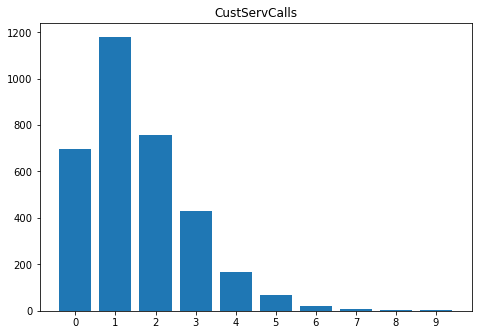

In [13]:
sizes=tdCustFr['xcnt']
labels=tdCustFr.reset_index(level=[0,1]).index

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels, sizes)
ax.set(title='CustServCalls')
plt.show()

In [14]:
hist = valib.Histogram(data=tdChurn, columns='allnumeric')
hist.result.head(160).sort(["xcol","xbin"])

xdb,xtbl,xcol,xbin,xbeg,xend,xcnt,xpct
LC250058,churn,AccountLength,1,1.0,25.2,99.0,2.9702970297029703
LC250058,churn,AccountLength,2,25.2,49.4,227.0,6.810681068106811
LC250058,churn,AccountLength,3,49.4,73.6,499.0,14.971497149714972
LC250058,churn,AccountLength,4,73.6,97.8,734.0,22.022202220222024
LC250058,churn,AccountLength,5,97.8,122.0,767.0,23.01230123012301
LC250058,churn,AccountLength,6,122.0,146.2,575.0,17.25172517251725
LC250058,churn,AccountLength,7,146.2,170.4,286.0,8.58085808580858
LC250058,churn,AccountLength,8,170.4,194.6,111.0,3.3303330333033303
LC250058,churn,AccountLength,9,194.6,218.8,28.0,0.8400840084008401
LC250058,churn,AccountLength,10,218.8,243.0,7.0,0.21002100210021002


## Step 3: Data Preparation
### Matriz de Correlaciones para las variables numéricas

In [15]:
Cor_Mat = valib.Matrix(data=tdChurn, columns='all', exclude_columns=["AreaCode","State","Churn","Phone"], type="COR")
# Print the results.
corr = Cor_Mat.result.to_pandas().sort_values(['rownum'])
corr

,,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,DayCalls,DayCharge,EveCalls,EveCharge,NightCalls,NightCharge,IntlCalls,IntlCharge,AccountLength,IntlPlan,VMailPlan
rownum,rowname,,,,,,,,,,,,,,,,,
1,VMailMessage,1.000000,0.000778,0.017562,0.007681,0.002856,-0.013263,-0.009548,0.000776,-0.005864,0.017578,0.007123,0.007663,0.013957,0.002884,-0.004628,0.008745,0.956927
2,DayMins,0.000778,1.000000,0.007043,0.004323,-0.010155,-0.013423,0.006750,1.000000,0.015769,0.007029,0.022972,0.004300,0.008033,-0.010092,0.006216,0.049396,-0.001684
3,EveMins,0.017562,0.007043,1.000000,-0.012584,-0.011035,-0.012985,-0.021451,0.007050,-0.011430,1.000000,0.007586,-0.012593,0.002541,-0.011067,-0.006757,0.019100,0.021545
4,NightMins,0.007681,0.004323,-0.012584,1.000000,-0.015207,-0.009288,0.022938,0.004324,-0.002093,-0.012592,0.011204,0.999999,-0.012353,-0.015180,-0.008955,-0.028905,0.006079
5,IntlMins,0.002856,-0.010155,-0.011035,-0.015207,1.000000,-0.009640,0.021565,-0.010157,0.008703,-0.011043,-0.013605,-0.015214,0.032304,0.999993,0.009514,0.045871,-0.001318
6,CustServCalls,-0.013263,-0.013423,-0.012985,-0.009288,-0.009640,1.000000,-0.018942,-0.013427,0.002423,-0.012987,-0.012802,-0.009277,-0.017561,-0.009675,-0.003796,-0.024522,-0.017824
7,DayCalls,-0.009548,0.006750,-0.021451,0.022938,0.021565,-0.018942,1.000000,0.006753,0.006462,-0.021449,-0.019557,0.022927,0.004574,0.021666,0.038470,0.003755,-0.011086
8,DayCharge,0.000776,1.000000,0.007050,0.004324,-0.010157,-0.013427,0.006753,1.000000,0.015769,0.007036,0.022972,0.004301,0.008032,-0.010094,0.006214,0.049398,-0.001686
9,EveCalls,-0.005864,0.015769,-0.011430,-0.002093,0.008703,0.002423,0.006462,0.015769,1.000000,-0.011423,0.007710,-0.002056,0.017434,0.008674,0.019260,0.006114,-0.006444


<AxesSubplot:ylabel='rownum-rowname'>

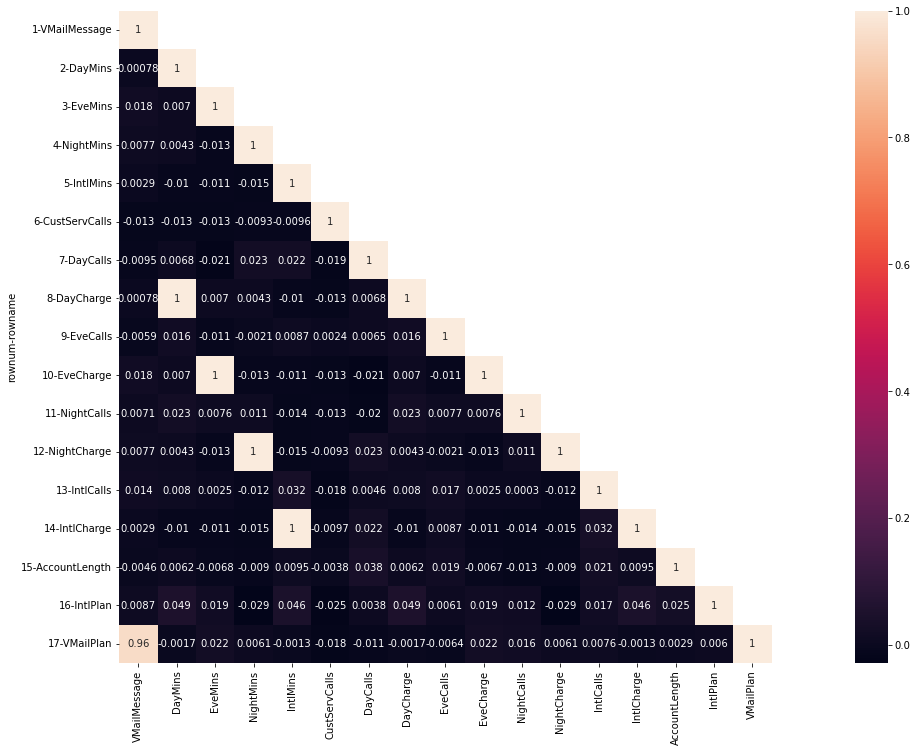

In [16]:
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=corr,mask=mask,square=True,annot=True,cbar=True)

### División de Muestras Train y Evaluation

In [17]:
tbl_sample = tdChurn.sample(frac = [0.7, 0.3])

In [18]:
df_train = tbl_sample[tbl_sample.sampleid == "1"].drop(["sampleid","AreaCode","State","DayCharge","EveCharge","NightCharge","IntlCharge","VMailPlan"], axis = 1)
copy_to_sql(df_train, schema_name="lc250058", table_name="ChurnTrainModel", if_exists="replace")
tbl_train = DataFrame(in_schema("lc250058","ChurnTrainModel"))
tbl_train.shape

(2333, 14)

In [19]:
df_test = tbl_sample[tbl_sample.sampleid == "2"].drop(["sampleid","AreaCode","State","DayCharge","EveCharge","NightCharge","IntlCharge","VMailPlan"], axis = 1)
copy_to_sql(df_test, schema_name="lc250058", table_name="ChurnTestModel", if_exists="replace")
tbl_test = DataFrame(in_schema("lc250058","ChurnTestModel"))
tbl_test.shape

(1000, 14)

## Step 4: Modeling
### Generación del Modelo de Regresión Logística (VAL)

In [20]:
tdModel = valib.LogReg(data=tbl_train,
                       columns="all",
                       exclude_columns="Phone",
                       stepwise=True,
                       response_column="Churn")
tdModel.model.to_pandas().sort_values(['Column Name'])

,B Coefficient,Standard Error,Wald Statistic,T Statistic,P-Value,Odds Ratio,Lower,Upper,Partial R,Standardized Coefficient
Column Name,,,,,,,,,,
(Constant),-9.405574,0.734746,163.868725,-12.801122,2.643612e-36,NaN,NaN,NaN,NaN,NaN
CustServCalls,0.531807,0.048311,121.177846,11.008081,0.000000e+00,1.702004,1.548241,1.871038,0.250570,0.383051
DayCalls,0.006781,0.003335,4.135286,2.033540,4.211140e-02,1.006804,1.000245,1.013406,0.033540,0.075404
DayMins,0.014305,0.001337,114.421664,10.696806,0.000000e+00,1.014408,1.011752,1.017070,0.243364,0.428659
EveMins,0.006998,0.001386,25.472404,5.047019,4.835585e-07,1.007022,1.004289,1.009762,0.111201,0.195863
IntlCalls,-0.080228,0.030401,6.964278,-2.638992,8.370859e-03,0.922906,0.869521,0.979569,-0.051140,-0.107619
IntlMins,0.109328,0.024897,19.283392,4.391286,1.177340e-05,1.115529,1.062401,1.171313,0.095421,0.166774
IntlPlan,1.996815,0.174993,130.207393,11.410845,0.000000e+00,7.365559,5.226989,10.379102,0.259889,0.330153
NightMins,0.004068,0.001335,9.290121,3.047970,2.329886e-03,1.004076,1.001453,1.006706,0.061972,0.114691


### Validación del Modelo de Regresión Logística (VAL)

In [21]:
tdModel.statistical_measures

rid,Total Observations,Total Iterations,Initial Log Likelihood,Final Log Likelihood,Likelihood Ratio Test G Statistic,Chi-Square Degrees of Freedom,Chi-Square Value,Chi-Square Probability,McFaddens Pseudo R-Squared,Dependent Variable,Dependent Response Value,Total Distinct Values
1,2333.0,6.0,-949.090138365859,-738.301847608809,421.576581514099,9.0,16.9189776046207,0.0,0.222095122724575,Churn,1.0,2.0


In [24]:
Logit_Model_Eval = valib.LogRegEvaluator(data=tbl_test, model=tdModel.model, index_columns="Phone", prob_column="Probability")

In [25]:
from IPython.core.display import display, HTML

cursor=td_context.raw_connection().cursor()
parms = 'database=' + Logit_Model_Eval.result._table_name.split('.')[0] + ';tablename=' + Logit_Model_Eval.result._table_name.split('.')[1] + ';analysistype=logisticscore'
cursor.callproc("trng_xsp.td_analyze", ['report',parms])
cursor.nextset()
z=cursor.fetchall()
# Loop in case of group by generating multiple reports
for i in range(len(z)):
    display(HTML(z[i][1]))

### Generación de un Modelo XGBoost (100% Python )

In [26]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [27]:
X_train = tbl_train.drop(["Phone", "Churn"], axis = 1).to_pandas()
y_train = tbl_train.select("Churn").to_pandas()
X_train.head()

,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,DayCalls,EveCalls,NightCalls,IntlCalls,AccountLength,IntlPlan
0,0,205.900,257.100,209.000,12.100,0,96,94,63,8,138,0
1,0,141.500,263.000,207.100,3.400,2,102,94,113,4,152,0
2,0,243.200,147.000,94.900,7.200,4,109,88,99,4,94,1
3,29,157.200,196.300,226.700,8.400,3,118,136,109,5,86,0
4,0,106.100,157.600,192.500,8.100,1,95,113,69,3,125,0


In [28]:
X_train.dtypes

VMailMessage      int64
DayMins          object
EveMins          object
NightMins        object
IntlMins         object
CustServCalls     int64
DayCalls          int64
EveCalls          int64
NightCalls        int64
IntlCalls         int64
AccountLength     int64
IntlPlan          int64
dtype: object

In [29]:
y_train.dtypes

Churn    int64
dtype: object

Cambiando los tipos de datos para poder operar en Python

In [30]:
X_test = tbl_test.drop(["Phone", "Churn"], axis = 1).to_pandas()
y_test = tbl_test.select("Churn").to_pandas()
X_test.head()

,VMailMessage,DayMins,EveMins,NightMins,IntlMins,CustServCalls,DayCalls,EveCalls,NightCalls,IntlCalls,AccountLength,IntlPlan
0,34,221.800,161.700,227.700,14.000,0,105,85,62,7,44,0
1,0,141.500,263.000,207.100,3.400,2,102,94,113,4,152,0
2,25,165.600,136.100,175.700,11.000,3,123,95,90,2,55,0
3,0,197.600,164.500,94.000,6.400,1,83,86,98,6,80,0
4,0,106.100,157.600,192.500,8.100,1,95,113,69,3,125,0


In [31]:
X_train.DayMins = X_train.DayMins.astype('float64')
X_train.EveMins = X_train.EveMins.astype('float64')
X_train.NightMins = X_train.NightMins.astype('float64')
X_train.IntlMins = X_train.IntlMins.astype('float64')
y_train.Churn = y_train.Churn.astype('int64')

X_test.DayMins = X_test.DayMins.astype('float64')
X_test.EveMins = X_test.EveMins.astype('float64')
X_test.NightMins = X_test.NightMins.astype('float64')
X_test.IntlMins = X_test.IntlMins.astype('float64')
y_test.Churn = y_test.Churn.astype('int64')

### Optimización de Parámetros de XGBoost utilizando GridSearchCV

In [32]:
from sklearn.model_selection import GridSearchCV         # Busqueda exhaustiva de la mejor combinacion
from sklearn.model_selection import RandomizedSearchCV   # Busqueda aleatoria de la mejor combinacion
from scipy.stats import randint as sp_randint

In [33]:
cv_params = {'max_depth': [2,3,4],
             'eta': [0.05,0.01,0.005],
             'n_estimators':[100,150,200]}

In [ ]:
xgb=XGBClassifier().fit(X_train, y_train)
optimized_XGB = RandomizedSearchCV(xgb, cv_params, scoring = 'accuracy', cv = 5) 
opXGB=optimized_XGB.fit(X_train, y_train)

In [36]:
print (optimized_XGB.best_params_)

{'n_estimators': 150, 'max_depth': 3, 'eta': 0.05}


Modelo con Parámetros óptimos (Para calcular la Importancia de las Variables)

In [37]:
model = XGBClassifier(n_estimators=150,max_depth=3,eta=0.05)
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)

[21:54:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.13488954 0.1506059  0.10222753 0.04715245 0.04769424 0.17069878
 0.02288759 0.0239461  0.0223506  0.06327105 0.01648135 0.19779487]


C:\TDAPPS\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\TDAPPS\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\TDAPPS\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


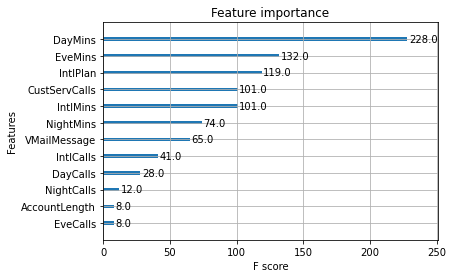

In [38]:
from matplotlib import pyplot
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

Exportando el Modelo óptimo utilizando el formato PMML

In [39]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml
pipeline = PMMLPipeline([("classifier", XGBClassifier(n_estimators=150,max_depth=3,eta=0.05))])
pipeline.fit(X_train, y_train)
sklearn2pmml(pipeline, "TelcoChurnPy.pmml", with_repr = True)

C:\TDAPPS\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\TDAPPS\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\TDAPPS\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[21:54:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [40]:
y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)[:, 1]
print('Area bajo la Curva ROC: ',roc_auc_score(y_test, y_probs))
print('Matriz de Confusión: ',confusion_matrix(y_test,y_pred))
print('Métricas de Clasificación: ', classification_report(y_test,y_pred))

Area bajo la Curva ROC:  0.9621387043189369
Matriz de Confusión:  [[857   3]
 [ 30 110]]
Métricas de Clasificación:                precision    recall  f1-score   support

           0       0.97      1.00      0.98       860
           1       0.97      0.79      0.87       140

    accuracy                           0.97      1000
   macro avg       0.97      0.89      0.93      1000
weighted avg       0.97      0.97      0.97      1000



## Step 5: Evaluation
### Haciendo Score de la base Test para calcular las métricas en Python

In [41]:
tdScore = valib.LogRegPredict(data=tbl_test, model=tdModel.model, index_columns="Phone", estimate_column="ChurnClass", prob_column="ChurnProb")
tdScore.result.head(5)

Phone,ChurnProb,ChurnClass
327-6087,0.049240417071349296,0.0
327-9289,0.019808374232075956,0.0
327-8495,0.5629961448418277,1.0
327-3850,0.045070979172530175,0.0
327-1058,0.007863688142408974,0.0


In [42]:
vec_con = tdScore.result.join(other = tbl_test.filter(items = ['Phone', 'Churn']), how = "inner", on = ["Phone"],
                             lsuffix = "predic", rsuffix = "orig")

In [43]:
vec_con.head()

predic_Phone,orig_Phone,ChurnProb,ChurnClass,Churn
327-6087,327-6087,0.049240417071349296,0.0,0
327-9289,327-9289,0.019808374232075956,0.0,0
327-9341,327-9341,0.027574411219751276,0.0,0
328-1206,328-1206,0.08797897017573708,0.0,0
328-2236,328-2236,0.017932226560643447,0.0,0
328-4231,328-4231,0.11034539715100897,0.0,0
328-2110,328-2110,0.022770992541124586,0.0,0
327-8495,327-8495,0.5629961448418277,1.0,1
327-3850,327-3850,0.045070979172530175,0.0,0
327-1058,327-1058,0.007863688142408974,0.0,0


### Comparando con las métricas del modelo XGBoost

In [44]:
vec = vec_con.to_pandas()
y_test = vec.Churn.astype('int64')
y_pred = vec.ChurnClass
y_probs = vec.ChurnProb
print('Area bajo la Curva ROC: ',roc_auc_score(y_test, y_probs))
print('Matriz de Confusión: ',confusion_matrix(y_test,y_pred))
print('Métricas de Clasificación: ', classification_report(y_test,y_pred))

Area bajo la Curva ROC:  0.856810631229236
Matriz de Confusión:  [[830  30]
 [106  34]]
Métricas de Clasificación:                precision    recall  f1-score   support

           0       0.89      0.97      0.92       860
           1       0.53      0.24      0.33       140

    accuracy                           0.86      1000
   macro avg       0.71      0.60      0.63      1000
weighted avg       0.84      0.86      0.84      1000



El Modelo con las mejores métricas es el de XGBoost. Será el que llevemos a Producción

## Step 6: Deployment
### Cargando el Modelo en Vantage

In [45]:
td_context.execute("DROP TABLE pmml_models;")

In [46]:
td_context.execute("CREATE SET TABLE pmml_models (model_id VARCHAR(40) CHARACTER SET LATIN NOT CASESPECIFIC, model BLOB(2097088000)) PRIMARY INDEX ( model_id );")

In [47]:
model_bytes = open("TelcoChurnPy.pmml", "rb").read()
td_context.execute("insert into pmml_models  (model_id, model) values(?,?)", 'churn_xgb_model', model_bytes)

C:\Users\lc250058\AppData\Local\Temp/ipykernel_11376/2953255088.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='TelcoChurnPy.pmml'>
  model_bytes = open("TelcoChurnPy.pmml", "rb").read()


In [48]:
pd.read_sql("select * from pmml_models", td_context)

,model_id,model
0,churn_xgb_model,"b'<?xml version=""1.0"" encoding=""UTF-8"" standal..."


### Proceso de Scoring del modelo XGBoost

In [49]:
td_context.execute("DROP TABLE ScoreResult;")

In [51]:
td_context.execute("CREATE TABLE ScoreResult AS ( \
SELECT * FROM TRNG_BYOM.PMMLPredict( \
    ON (SELECT * FROM new_churn) \
    ON (select * from pmml_models where model_id='churn_xgb_model') DIMENSION \
    USING \
        Accumulate('Phone') \
        ModelOutputFields ('probability(0)', 'probability(1)') \
) AS dt \
) WITH DATA;")

In [52]:
td_context.execute('UPDATE ScoreResult SET prediction=0 WHERE "probability(0)" GT "probability(1)";')

In [53]:
td_context.execute('UPDATE ScoreResult SET prediction=1 WHERE "probability(1)" GT "probability(0)";')

In [54]:
result_df = DataFrame.from_query("select top 10 * FROM ScoreResult;")
result_df.head()

Phone,prediction,probability(0),probability(1)
336-5406,0,0.917269701668967,0.08273029833103301
338-1840,0,0.915927124841825,0.08407287515817491
340-4627,0,0.947300771663264,0.052699228336735966
348-9938,0,0.8542437951675639,0.14575620483243615
360-6024,0,0.9486567110482776,0.051343288951722355
362-4685,0,0.9743250638791223,0.025674936120877647
356-2302,0,0.9683817655729903,0.03161823442700971
336-6907,0,0.9668744814407676,0.033125518559232354
336-1353,0,0.9619859635854923,0.0380140364145077
327-6087,0,0.9853824327642314,0.01461756723576852


In [55]:
remove_context()

True

Copyright 2023. Elaborado por Luis Cajachahua bajo licencia MIT